In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

We will use a very simple wine dataset

In [2]:
from sklearn.datasets import load_wine
from sklearn.model_selection import KFold
data = load_wine()

In [3]:
features=data.feature_names
print(features)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


Classifying the type of red wine from features of the wine such as the alchohol and other chemical components. There are three possible wine types

In [4]:
target_names=data.target_names
print(target_names)


['class_0' 'class_1' 'class_2']


In [7]:
X=data.data
#print(X.shape)
y=data.target
#print(y.shape)
print("number of features : {}".format(X.shape[1]))
print("number of samples : {}".format(X.shape[0]))
print("number of classes : {}".format(np.unique(y).size))


number of features : 13
number of samples : 178
number of classes : 3


Normalizing the data using StandardScaler

In [10]:
from sklearn.preprocessing import StandardScaler
scaling=StandardScaler(copy=True, with_mean=True, with_std=True)
scaling.fit(X)
Xs=scaling.transform(X)

In [11]:
from sklearn.decomposition import PCA
ncomp = 2
pca = PCA(n_components=ncomp, svd_solver='randomized', whiten=True)
pca.fit(Xs)
Z=pca.transform(Xs)

Starting indices of each class

In [14]:
np.unique(y, return_index=True)

(array([0, 1, 2]), array([  0,  59, 130], dtype=int64))

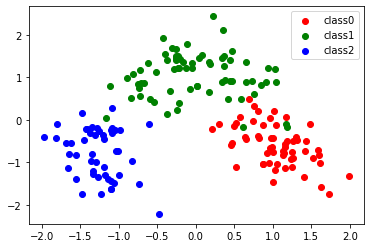

In [15]:
X_class0 = Z[0:58:,[0]]
Y_class0 = Z[0:58:,[1]]
plt.scatter(X_class0,Y_class0,c='red')
X_class1 = Z[59:129:,[0]]
Y_class1 = Z[59:129:,[1]]
plt.scatter(X_class1,Y_class1,c='green')
X_class2 = Z[130:,[0]]
Y_class2 = Z[130:,[1]]
plt.scatter(X_class2,Y_class2,c='blue')
plt.legend(['class0','class1','class2'],loc='upper right')

PCA is used as a preprocessing step. In this case we will use cross validation to find the best accuracy for various PC's

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
nfold = 5
# Create a K-fold object
kf = KFold(n_splits=nfold)
kf.get_n_splits(X)
# Number of PCs to try
ncomp_test = np.arange(2,12)
num_nc = len(ncomp_test)
# Accuracy: acc[icomp,ifold] is test accuracy when using `ncomp = ncomp_test[ic
acc = np.zeros((num_nc,nfold))
# Loop over number of components to test
for icomp, ncomp in enumerate(ncomp_test):

 # Look over the folds
    for ifold, I in enumerate(kf.split(X)):
        Itr, Its = I
        Xtr = X[Itr]
        ytr = y[Itr]
        Xts = X[Its]
        yts = y[Its]
 # TODO: Create a scaling object and fit the scaling on the training data
 #FOR TRAINING DATA
        scaling=StandardScaler(copy=True, with_mean=True, with_std=True)
        scaling.fit(Xtr)
        Xtrs=scaling.transform(Xtr)


        pca = PCA(n_components=ncomp, svd_solver='randomized', whiten=True)
        pca.fit(Xtrs)


         #Z_tr=pca_1.transform(Xtrs)

        Xtrs_new=pca.transform(Xtrs)



 #pca_2 = PCA(n_components=ncomp, svd_solver='randomized', whiten=True)
 #pca_2.fit(Xtss)
 #Z_ts=pca_2.transform(Xtss)

 # TODO: Fit the PCA on the scaled training data
 # TODO: Train a classifier on the transformed training data
 # Use a logistic regression classifier
        logreg = LogisticRegression(multi_class='auto', solver='lbfgs')
        logreg.fit(Xtrs_new, ytr)

        Xtss=scaling.transform(Xts)
        Xtss_new=pca.transform(Xtss)
        yhat = logreg.predict(Xtss_new)
 # TODO: Transform the test data through data scaler and PCA
 # TODO: Predict the labels the test data

 # TODO: Measure the accuracy
        acc[icomp, ifold] = np.mean(yhat == yts)

Optimal order using normal rule is : 11
Accuracy 0.955397
Optimal model order with one SE rule : 7
Accuracy 0.949524


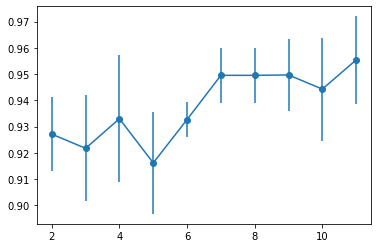

In [18]:
acc_mean = np.mean(acc,axis=1)
acc_se = np.std(acc,axis = 1)/np.sqrt(nfold-1)
plt.errorbar(ncomp_test,acc_mean,marker = 'o', yerr = acc_se)
imax = np.argmax(acc_mean)
print("Optimal order using normal rule is :",ncomp_test[imax])
print('Accuracy %f' % acc_mean[imax])
acc_tgt = acc_mean[imax] - acc_se[imax]
I = np.where(acc_mean >= acc_tgt)[0]
iopt = I[0]
dopt = ncomp_test[iopt]
print('Optimal model order with one SE rule : %d' % dopt)
print('Accuracy %f' % acc_mean[iopt])

We will now try a more complex classifier -- a support vector classifier with a radial basis function. When we use such a classifer, there will be a number of parameters to tune. When the number of parameters to tune becomes large, writing a loop over multiple parameters as we did above becomes cumbersome. The sklearn package has a very nice routine, GridSearchCV to perform this sort of parameter search.

Before, we do this we need to create an estimator Pipeline. An estimator pipeline is a sequence of transformations followed by an estimator that will operate on the transformed data. Create the following pipeline:

Create a StandardScaler() object called scaler for the first transformation
Create a PCA() object called pca for the second transformation
Create a SVC() object called svc for the final SVM classifier. Set the parameter kernel='rbf'.
Once you have the three steps defined, you can create the pipeline with the command:

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', svc)])

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# TODO
scaler = StandardScaler()
pca = PCA()
svc = SVC(kernel='rbf')
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', svc)])


In [21]:
ncomp_test = np.arange(3,11)
c_test= np.array([10**-2, 10**-1,10**0,10**1,10**2,10**3])
gam_test=np.array([10**-3, 10**-2,10**-1,10**0,10**1])

In [22]:
params = {'pca__n_components': ncomp_test, 'svc__C' : c_test, 'svc__gamma': gam_test}

In [23]:
estimator = GridSearchCV(estimator = pipe,param_grid=params, cv=5, iid=False)
estimator.fit(X,y)

C:\Users\Blackfish96\miniconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('svc', SVC())]),
             iid=False,
             param_grid={'pca__n_components': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                         'svc__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])})

In [24]:
estimator.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__scaler', 'estimator__pca', 'estimator__svc', 'estimator__scaler__copy', 'estimator__scaler__with_mean', 'estimator__scaler__with_std', 'estimator__pca__copy', 'estimator__pca__iterated_power', 'estimator__pca__n_components', 'estimator__pca__random_state', 'estimator__pca__svd_solver', 'estimator__pca__tol', 'estimator__pca__whiten', 'estimator__svc__C', 'estimator__svc__break_ties', 'estimator__svc__cache_size', 'estimator__svc__class_weight', 'estimator__svc__coef0', 'estimator__svc__decision_function_shape', 'estimator__svc__degree', 'estimator__svc__gamma', 'estimator__svc__kernel', 'estimator__svc__max_iter', 'estimator__svc__probability', 'estimator__svc__random_state', 'estimator__svc__shrinking', 'estimator__svc__tol', 'estimator__svc__verbose', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [25]:
bst_score=estimator.best_score_
bst_pram=estimator.best_params_
print("best test score is {}".format(bst_score))
print("best parameter is {}".format(bst_pram))
test_score = estimator.cv_results_['mean_test_score']

best test score is 0.9777777777777779
best parameter is {'pca__n_components': 5, 'svc__C': 1.0, 'svc__gamma': 0.1}
